# Dpi Setting

In [9]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#numpy2ri.activate()

rng = gs.random.rng()

In [10]:
!apt-get install -y r-base
#!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [11]:
from rpy2.robjects.packages import importr

import numpy as np
from rpy2.robjects import numpy2ri, default_converter, globalenv
from rpy2.robjects.conversion import localconverter

In [12]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### R

In [13]:
%%R

#library(spcosa)
#ibrary(spsurvey)
if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/local/lib/R/site-library’ contains no packages


In [14]:
sampling = importr('sampling')

# Reduce Population to N=100

In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# — adjust these paths as needed —
input_dir  = "/home/divar/projects/graphical-sampling/data_samples/coords_probs"
output_dir = "/home/divar/projects/graphical-sampling/data_samples/coords_probs"
os.makedirs(output_dir, exist_ok=True)

# — only process these six populations —
pop_names = [
    "grid_eq",
    "grid_uneq",
    "clust_eq",
    "clust_uneq",
    "random_eq",
    "random_uneq"
]

K = 100           # number of clusters for non-grid pops
SEED = 42         # for reproducibility

for pop in pop_names:
    in_path = os.path.join(input_dir, f"{pop}.csv")
    if not os.path.exists(in_path):
        print(f"⚠️  File not found: {in_path} – skipping.")
        continue

    print(f"▶ Processing {pop}.csv")

    # 1) load full population
    df = pd.read_csv(in_path)

    # 2a) special handling for grid pops: pick a 10×10 subsample on the regular 20×20
        # … inside your for‑pop loop, replace the grid_* section with this:

    if pop in ("grid_eq", "grid_uneq"):
        df = pd.read_csv(in_path)
        # sort the unique coordinates
        ux = np.sort(df["x"].unique())
        uy = np.sort(df["y"].unique())

        # step = 20 / 10 = 2  → pick indices 0,2,4,…,18
        step_x = len(ux) // 10
        step_y = len(uy) // 10

        ix = np.arange(10) * step_x   # [0,2,4,…,18]
        iy = np.arange(10) * step_y

        x_sel = ux[ix]
        y_sel = uy[iy]

        # take only the points whose x∈x_sel AND y∈y_sel
        df_reduced = df[df["x"].isin(x_sel) & df["y"].isin(y_sel)].reset_index(drop=True)

        print(f"  grid: picked indices {ix.tolist()} on x, {iy.tolist()} on y")
        print(f"  resulting sub‑grid spans x=({x_sel.min():.3f}…{x_sel.max():.3f})")

    # 2b) clustering for the other four
    else:
        coords = df[["x","y"]].values
        kmeans = KMeans(n_clusters=K, random_state=SEED)
        labels = kmeans.fit_predict(coords)
        centers = kmeans.cluster_centers_

        keep = []
        for k in range(K):
            mask     = (labels == k)
            pts      = coords[mask]
            dists    = np.linalg.norm(pts - centers[k], axis=1)
            orig_idx = np.flatnonzero(mask)
            nearest  = orig_idx[np.argmin(dists)]
            keep.append(nearest)
        df_reduced = df.iloc[keep].reset_index(drop=True)

    # 3) save reduced CSV
    out_csv = os.path.join(output_dir, f"{pop}_N=100.csv")
    df_reduced.to_csv(out_csv, index=False)
    print(f"  ✔ saved {out_csv}  ({len(df_reduced)} rows)")

    # 4) scatter‐plot for confirmation
    plt.figure(figsize=(4,4))
    plt.scatter(df_reduced["x"], df_reduced["y"], s=10)
    plt.title(f"{pop}_N=100 ({len(df_reduced)} pts)")
    plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout()
    out_png = os.path.join(output_dir, f"{pop}_N=100_scatter.png")
    plt.savefig(out_png)
    plt.close()
    print(f"  ✔ plotted {out_png}\n")


⚠️  File not found: /home/divar/projects/graphical-sampling/data_samples/coords_probs/grid_eq.csv – skipping.
⚠️  File not found: /home/divar/projects/graphical-sampling/data_samples/coords_probs/grid_uneq.csv – skipping.
⚠️  File not found: /home/divar/projects/graphical-sampling/data_samples/coords_probs/clust_eq.csv – skipping.
⚠️  File not found: /home/divar/projects/graphical-sampling/data_samples/coords_probs/clust_uneq.csv – skipping.
⚠️  File not found: /home/divar/projects/graphical-sampling/data_samples/coords_probs/random_eq.csv – skipping.
⚠️  File not found: /home/divar/projects/graphical-sampling/data_samples/coords_probs/random_uneq.csv – skipping.


grid_eq_N=100: 100 points


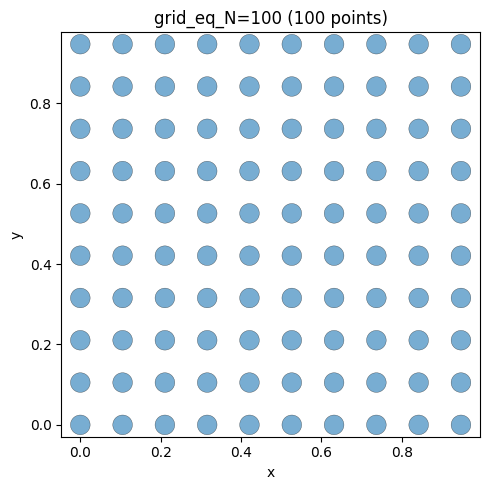

grid_uneq_N=100: 100 points


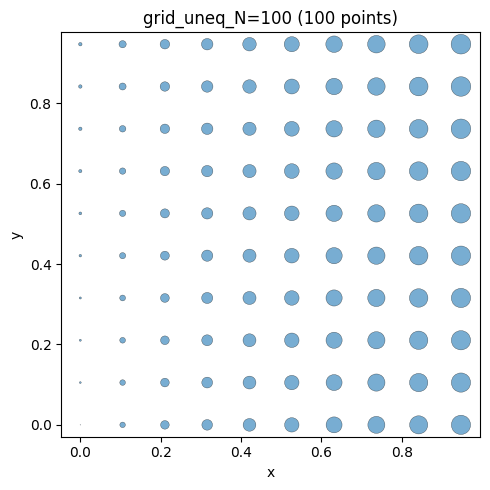

clust_eq_N=100: 100 points


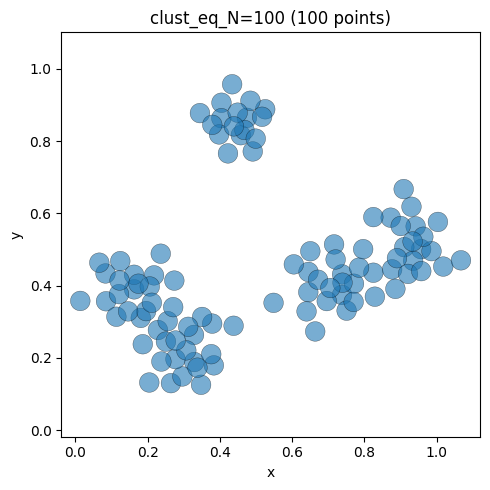

clust_uneq_N=100: 100 points


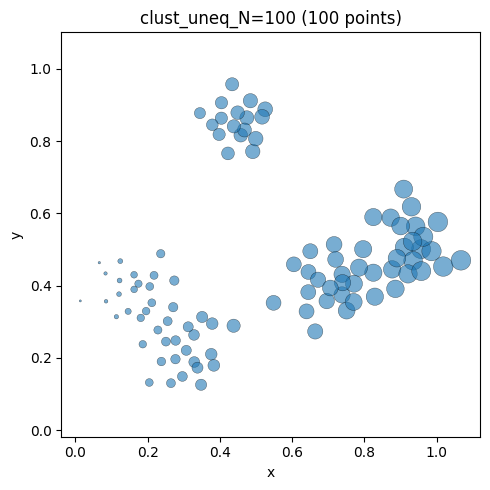

random_eq_N=100: 100 points


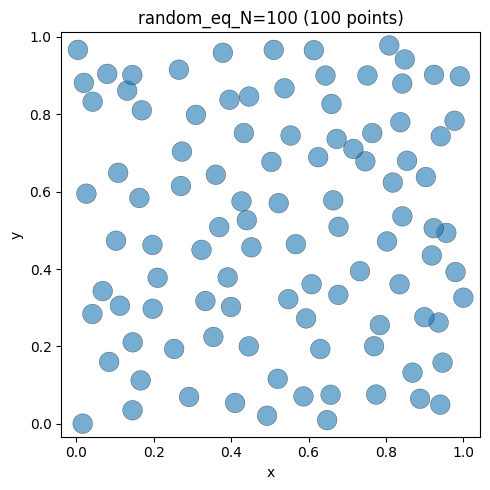

random_uneq_N=100: 100 points


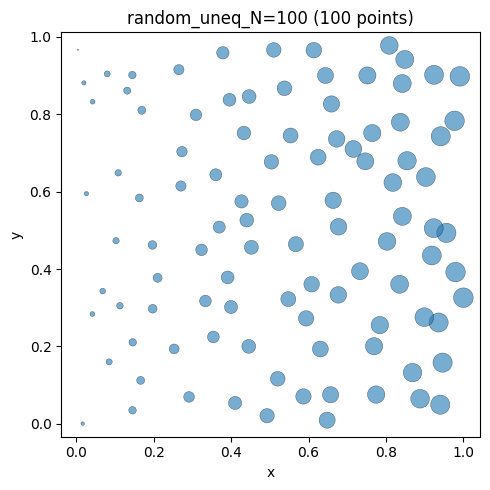

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directory containing the reduced CSVs
input_dir = "/home/divar/projects/graphical-sampling/data_samples/coords_probs"

# Six population names
pop_names = [
    "grid_eq",
    "grid_uneq",
    "clust_eq",
    "clust_uneq",
    "random_eq",
    "random_uneq"
]

for pop in pop_names:
    file_path = os.path.join(input_dir, f"{pop}_N=100.csv")
    df = pd.read_csv(file_path)
    
    print(f"{pop}_N=100: {df.shape[0]} points")
    
    # normalize probs to [0,1] and scale up for marker size
    # (you can change 200 to a larger/smaller value)
    sizes = (df["prob"] / df["prob"].max()) * 200
    
    plt.figure(figsize=(5,5))
    plt.scatter(df["x"], df["y"],
                s=sizes,       # marker size ∝ prob
                alpha=0.6,     # some transparency
                edgecolor="k", # optional: black border
                linewidth=0.3)
    plt.title(f"{pop}_N=100 ({df.shape[0]} points)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


# Simulation

In [13]:
%%R
# install.packages("sampling")     # if you haven’t already
library(sampling)

## —— PATHS —— ##
input_dir  <- "/home/divar/projects/graphical-sampling/data_samples/coords_probs"
output_dir <- "/home/divar/projects/graphical-sampling/data_samples/results"
dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

## —— SETTINGS —— ##
pop_names <- c(
  # "grid_eq_N=100",
  # "grid_uneq_N=100",
  # "cluster_eq_N=100",
  # "cluster_uneq_N=100",
  # "random_eq_N=100",
  # "random_uneq_N=100"
  "swiss_eq_fake_N=100",
  "swiss_uneq_fake_N=100" 
)

n_values <- c(4, 8, 16)     # sample sizes to try
M        <- 2000            # replicates per method
methods  <- c("wave", "UPmaxentropy", "lpm1", "lpm2", "srs")

## —— MAIN LOOP —— ##
for (n in n_values) {
  message("▶▶ Building merged table for n = ", n)
  
  all_samples <- vector("list", length = 0)
  
  for (pop in pop_names) {
    pop_file <- file.path(input_dir, paste0(pop, ".csv"))
    if (!file.exists(pop_file)) {
      warning("File not found, skipping: ", pop_file)
      next
    }
    
    pop_df <- read.csv(pop_file)
    coords <- as.matrix(pop_df[, c("x","y")])
    orig_p <- pop_df$prob
    pik    <- inclusionprobabilities(orig_p, n)
    
    for (method in methods) {
      message("  • ", pop, " – ", method)
      samples_idx <- matrix(NA_integer_, nrow = M, ncol = n)
      pb <- txtProgressBar(min = 0, max = M, style = 3)
      
      for (rep in seq_len(M)) {
        if (method == "wave") {
          sel <- wave(coords, pik);      idx <- which(sel == 1)
        } else if (method == "UPmaxentropy") {
          sel <- UPmaxentropy(pik);      idx <- which(sel == 1)
        } else if (method == "lpm1") {
          sel <- lpm1(pik, coords);      idx <- sel 
        } else if (method == "lpm2") {
          sel <- lpm(pik, coords);       idx <- sel
        } else if (method == "srs") {
          idx <- sample.int(nrow(pop_df), size = n)
        }
        samples_idx[rep, ] <- idx
        setTxtProgressBar(pb, rep)
      }
      close(pb)
      
      # convert to data.frame & add metadata
      df_idx <- as.data.frame(samples_idx, stringsAsFactors = FALSE)
      names(df_idx) <- paste0("idx", seq_len(n))
      df_idx$rep    <- seq_len(M)
      df_idx$method <- method
      df_idx$pop    <- pop
      
      # reorder columns: pop, method, rep, idx1…idxn
      df_idx <- df_idx[, c("pop","method","rep", paste0("idx", seq_len(n)))]
      
      all_samples[[ length(all_samples)+1 ]] <- df_idx
    }
  }
  
  # bind them all and write one CSV for this n
  merged <- do.call(rbind, all_samples)
  out_fn <- sprintf("samples_swiss_n=%d_wide.csv", n)
  out_fp <- file.path(output_dir, out_fn)
  write.csv(merged, file = out_fp, row.names = FALSE)
  message("✔ Written merged file: ", out_fp, "  (", nrow(merged), " rows )\n")
}


  |                                                                            

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

▶▶ Building merged table for n = 4
  • swiss_eq_fake_N=100 – wave
  • swiss_eq_fake_N=100 – UPmaxentropy
  • swiss_eq_fake_N=100 – lpm1
  • swiss_eq_fake_N=100 – lpm2
  • swiss_eq_fake_N=100 – srs
  • swiss_uneq_fake_N=100 – wave
  • swiss_uneq_fake_N=100 – UPmaxentropy
  • swiss_uneq_fake_N=100 – lpm1
  • swiss_uneq_fake_N=100 – lpm2
  • swiss_uneq_fake_N=100 – srs
✔ Written merged file: /home/divar/projects/graphical-sampling/data_samples/results/samples_swiss_n=4_wide.csv  (20000 rows )

▶▶ Building merged table for n = 8
  • swiss_eq_fake_N=100 – wave
  • swiss_eq_fake_N=100 – UPmaxentropy
  • swiss_eq_fake_N=100 – lpm1
  • swiss_eq_fake_N=100 – lpm2
  • swiss_eq_fake_N=100 – srs
  • swiss_uneq_fake_N=100 – wave
  • swiss_uneq_fake_N=100 – UPmaxentropy
  • swiss_uneq_fake_N=100 – lpm1
  • swiss_uneq_fake_N=100 – lpm2
  • swiss_uneq_fake_N=100 – srs
✔ Written merged file: /home/divar/projects/graphical-sampling/data_samples/results/samples_swiss_n=8_wide.csv  (20000 rows )

▶▶ Build

# Analyse the results

## All cpus

In [29]:
import os, glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# ─── Bring in your R bridge and activate converters ───
import rpy2.robjects as ro


from rpy2.robjects import globalenv, default_converter
from rpy2.robjects.conversion import localconverter
import rpy2.robjects.numpy2ri as numpy2ri

# ─── Your scores() function, unchanged ───
def scores(coords, probs, n, N, sample_idx, split_size=0.001, density_measure=None):
    assert len(coords)==len(probs)==N
    assert len(sample_idx)==n

    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    with localconverter(default_converter + numpy2ri.converter):
        globalenv['sample_mask'] = sample_mask
        globalenv['sample_idx']  = sample_idx + 1
        globalenv['coords']      = coords
        globalenv['probs']       = probs
        globalenv['n']           = n
        globalenv['N']           = N

    # Now these calls will succeed because sampling & spdep are loaded
    ro.r("""
W <- wpik(coords,probs)
W <- W - diag(diag(W)); diag(W)<-0

ib_value   <- tryCatch(IB(W, sample_mask),    error=function(e) Inf)
sb_value   <- tryCatch(sb(probs, coords, sample_idx),    error=function(e) Inf)
sblb_value <- tryCatch(sblb(probs, coords, sample_idx),  error=function(e) Inf)
""")

    IB_value   = float(ro.r("ib_value")[0])
    SB_value   = float(ro.r("sb_value")[0])
    SBLB_value = float(ro.r("sblb_value")[0])

    if density_measure is None:
        sc = (coords - coords.min(axis=0)) / np.ptp(coords, axis=0)
        density_measure = gs.measure.Density(sc, probs, n, split_size=split_size)
    density_val = density_measure.score(sample_idx.reshape(1,-1))[0]

    return density_val, SB_value, SBLB_value

# ─── Worker to score one replicate ───
def process_row(task):
    pop, method, n, rep, idx = task

    # strip "_fake" if your pop still has it
    pop_clean = pop.replace("_fake","")
    coords_fp  = os.path.join(COORDS_DIR, f"{pop_clean}.csv")
    pop_df     = pd.read_csv(coords_fp)
    coords     = pop_df[["x","y"]].to_numpy()
    probs      = pop_df["prob"].to_numpy()
    N          = len(probs)

    try:
        d, sb, lb = scores(coords, probs, n, N, idx)
    except Exception as e:
        # now you’ll at least see real errors if you remove this
        d, sb, lb = (np.nan, np.nan, np.nan)

    return {
        "pop":            pop,
        "method":         method,
        "n":              n,
        "rep":            rep,
        "Density":        d,
        "SpatialBalance": sb,
        "LocalBalance":   lb
    }

# ─── Main ───
if __name__=="__main__":
    SAMPLE_DIR = "/home/divar/projects/graphical-sampling/data_samples/samples"
    COORDS_DIR = "/home/divar/projects/graphical-sampling/data_samples/coords_probs"

    # Pick your Swiss file:
    SAMPLE_FILE = "samples_swiss_n=8_wide.csv"
    df_s        = pd.read_csv(os.path.join(SAMPLE_DIR, SAMPLE_FILE))
    idx_cols    = [c for c in df_s if c.startswith("idx")]

    tasks = []
    for _, row in df_s.iterrows():
        sample_idx = row[idx_cols].to_numpy(int) - 1
        tasks.append((row["pop"], row["method"], len(idx_cols), int(row["rep"]), sample_idx))

    print(f"→ Scoring {len(tasks)} reps on {os.cpu_count()} cores…")
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as exe:
        results = list(tqdm(exe.map(process_row, tasks),
                            total=len(tasks),
                            desc="Scoring",
                            unit="rep"))

    out = os.path.join(SAMPLE_DIR, SAMPLE_FILE.replace(".csv","_scores.csv"))
    pd.DataFrame(results).to_csv(out, index=False)
    print("✔ Done; results in", out)


→ Scoring 20000 reps on 12 cores…


Scoring: 100%|██████████| 20000/20000 [3:20:05<00:00,  1.67rep/s]  


✔ Done; results in /home/divar/projects/graphical-sampling/data_samples/samples/samples_swiss_n=8_wide_scores.csv


## One cpu

In [24]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# rpy2 imports for your scores()
import rpy2.robjects as ro
from rpy2.robjects import globalenv, default_converter
from rpy2.robjects.conversion import localconverter
import rpy2.robjects.numpy2ri as numpy2ri

# ————————————————————————————————
# your exact scores() function, unchanged
def scores(coords, probs, n, N, sample_idx, split_size=0.001, density_measure=None):
    assert len(coords)==len(probs)==N
    assert len(sample_idx)==n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    with localconverter(default_converter + numpy2ri.converter):
        globalenv['sample_mask'] = sample_mask
        globalenv['sample_idx']  = sample_idx + 1
        globalenv['coords']      = coords
        globalenv['probs']       = probs
        globalenv['n']           = n
        globalenv['N']           = N

    ro.r("""
W <- wpik(coords,probs)
W <- W - diag(diag(W)); diag(W)<-0

ib_value <- tryCatch(IB(W, sample_mask),   error=function(e) Inf)
sb_value <- tryCatch(sb(probs, coords, sample_idx),   error=function(e) Inf)
sblb_value <- tryCatch(sblb(probs, coords, sample_idx), error=function(e) Inf)
""")
    IB_value   = float(ro.r("ib_value")[0])
    SB_value   = float(ro.r("sb_value")[0])
    SBLB_value = float(ro.r("sblb_value")[0])

    if density_measure is None:
        sc = (coords - coords.min(axis=0)) / np.ptp(coords, axis=0)
        density_measure = gs.measure.Density(sc, probs, n, split_size=split_size)
    density_val = density_measure.score(sample_idx.reshape(1,-1))[0]

    return density_val, SB_value, SBLB_value

# ————————————————————————————————
if __name__=="__main__":
    # ── adjust these as needed ──
    SAMPLE_DIR = "/home/divar/projects/graphical-sampling/data_samples/samples"
    COORDS_DIR = "/home/divar/projects/graphical-sampling/data_samples/coords_probs"

    # ── pick one Swiss sample file ──
    SAMPLE_FILE = "samples_swiss_n=8_wide.csv"   # swap in n=4 or n=16 as needed
    samp_path   = os.path.join(SAMPLE_DIR, SAMPLE_FILE)

    df_s = pd.read_csv(samp_path)
    idx_cols = [c for c in df_s.columns if c.startswith("idx")]

    out_file = SAMPLE_FILE.replace(".csv", "_scores.csv")
    out_path = os.path.join(SAMPLE_DIR, out_file)
    if os.path.exists(out_path):
        os.remove(out_path)

    print(f"Scoring {SAMPLE_FILE} ({len(df_s)} replicates)…")
    results = []
    for _, row in tqdm(df_s.iterrows(), total=len(df_s), desc="Scoring"):
        pop        = row["pop"]       # e.g. "swiss_eq_N=100" or "swiss_uneq_N=100"
        method     = row["method"]
        rep        = int(row["rep"])
        n          = len(idx_cols)
        sample_idx = row[idx_cols].to_numpy(int) - 1

        # now load exactly pop+".csv"
        coords_fp = os.path.join(COORDS_DIR, f"{pop}.csv")
        pop_df    = pd.read_csv(coords_fp)
        coords    = pop_df[["x","y"]].to_numpy()
        probs     = pop_df["prob"].to_numpy()
        N         = len(probs)

        d, sb, lb = scores(coords, probs, n, N, sample_idx)
        results.append({
            "pop":            pop,
            "method":         method,
            "n":              n,
            "rep":            rep,
            "Density":        d,
            "SpatialBalance": sb,
            "LocalBalance":   lb
        })

        # stream to disk so you can watch progress
        pd.DataFrame(results).to_csv(out_path, index=False)

    print(f"\n✔ Done!  Written {len(results)} rows to:\n  {out_path}")


Scoring samples_swiss_n=8_wide.csv (20000 replicates)…


Scoring:   3%|▎         | 694/20000 [09:07<4:13:51,  1.27it/s] 


KeyboardInterrupt: 

In [ ]:
import os
import glob
import re
import numpy as np
import pandas as pd

# rpy2 imports (for your scores function)
import rpy2.robjects as ro
from rpy2.robjects import globalenv, default_converter
from rpy2.robjects.conversion import localconverter
import rpy2.robjects.numpy2ri as numpy2ri

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# ————————————————————————————————
# YOUR EXACT scores(...) FUNCTION
def scores(coords, probs, n, N, sample_idx, split_size=0.001, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    with localconverter(default_converter + numpy2ri.converter):
        globalenv['sample_mask'] = sample_mask
        globalenv['sample_idx']  = sample_idx + 1
        globalenv['coords']      = coords
        globalenv['probs']       = probs
        globalenv['n']           = n
        globalenv['N']           = N

    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0

ib_value <- tryCatch({
  IB(W, sample_mask)
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value   = float(ro.r("ib_value")[0])
    SB_value   = float(ro.r("sb_value")[0])
    SBLB_value = float(ro.r("sblb_value")[0])

    if density_measure is None:
        scaled_coords   = (coords - coords.min(axis=0)) / np.ptp(coords, axis=0)
        density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=split_size)

    density_val = density_measure.score(sample_idx.reshape(1, -1))[0]
    return density_val, SB_value, SBLB_value

# ————————————————————————————————
# worker that unwraps a task and calls scores()
def process_row(task):
    pop, method, n, rep, sample_idx = task

    # pick the right coords file (handles both "_N=100.csv" and no suffix)
    pattern = os.path.join(COORDS_DIR, f"{pop}*.csv")
    matches = glob.glob(pattern)
    if len(matches) != 1:
        raise FileNotFoundError(f"No unique coords file for '{pop}': {matches}")
    pop_df = pd.read_csv(matches[0])
    coords = pop_df[["x","y"]].to_numpy()
    probs  = pop_df["prob"].to_numpy()
    N      = len(probs)

    try:
        d, sb, lb = scores(coords, probs, n, N, sample_idx)
    except Exception:
        d, sb, lb = (np.nan, np.nan, np.nan)

    return {
        "pop":          pop,
        "method":       method,
        "n":            n,
        "rep":          rep,
        "Density":      d,
        "SpatialBalance": sb,
        "LocalBalance":  lb
    }

# ————————————————————————————————
if __name__ == "__main__":
    # ── ADJUST THESE PATHS AS NEEDED ──
    SAMPLE_DIR = "/home/divar/projects/graphical-sampling/data_samples/samples"
    COORDS_DIR = "/home/divar/projects/graphical-sampling/data_samples/coords_probs"

    # find every "wide" sample file
    rgx   = re.compile(r".*_n=(\d+)_wide\.csv$")
    files = glob.glob(os.path.join(SAMPLE_DIR, "samples*_n=*_*wide.csv"))
    print(f"→ Found {len(files)} sample‑files in {SAMPLE_DIR}")

    # build the full task list
    tasks = []
    for fp in files:
        m = rgx.match(os.path.basename(fp))
        if not m:
            continue
        n    = int(m.group(1))
        df   = pd.read_csv(fp)
        idxs = [c for c in df.columns if c.startswith("idx")]

        for _, row in df.iterrows():
            pop_val    = row["pop"]
            method_val = row["method"]
            rep_val    = int(row["rep"])
            sample_idx = row[idxs].to_numpy(dtype=int) - 1
            tasks.append((pop_val, method_val, n, rep_val, sample_idx))

    print(f"→ Total replicates to score: {len(tasks)}")

    # prepare output
    out_file = os.path.join(SAMPLE_DIR, "final_scores.csv")
    if os.path.exists(out_file):
        os.remove(out_file)

    # ── CONTROL YOUR RESOURCES ──
    MAX_WORKERS = min(5, os.cpu_count())
    BATCH_SIZE  = 100   # append every 100 rows
    buffer      = []
    print(f"→ Running with up to {MAX_WORKERS} workers, flushing every {BATCH_SIZE} rows")

    # ── PARALLEL LOOP ──
    with ProcessPoolExecutor(max_workers=MAX_WORKERS) as exe:
        for i, result in enumerate(tqdm(exe.map(process_row, tasks),
                                        total=len(tasks),
                                        desc="Scoring",
                                        unit="task"), start=1):
            buffer.append(result)
            if i % BATCH_SIZE == 0:
                pd.DataFrame(buffer).to_csv(
                    out_file,
                    mode="a",
                    header=not os.path.exists(out_file),
                    index=False
                )
                buffer.clear()

    # flush any remainder
    if buffer:
        pd.DataFrame(buffer).to_csv(
            out_file,
            mode="a",
            header=not os.path.exists(out_file),
            index=False
        )

    print(f"✔ Done – streaming results into:\n   {out_file}")


→ Found 9 sample‑files in /home/divar/projects/graphical-sampling/data_samples/samples
→ Total replicates to score: 300000
→ Running with up to 5 workers, flushing every 100 rows


R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operator(): index out of bounds
  
R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operator(): index out of bounds
  
R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operator(): index out of bounds
  
R callback write-console: In addition:   
R callback write-console: In addition:   
R callback write-console: In addition:   
R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operator(): index out of bounds
  
R callback write-console: Warning message:
  
R callback write-console: Warning message:
  
R callback write-console: Warning message:
  
R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operat

In [ ]:
import os, glob, re
import numpy as np
import pandas as pd

# rpy2 imports
import rpy2.robjects as ro
from rpy2.robjects import globalenv, default_converter
from rpy2.robjects.conversion import localconverter
import rpy2.robjects.numpy2ri as numpy2ri


from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# ——————————————————————
# scoring function
def scores(coords, probs, n, N, sample_idx, split_size=0.001, density_measure=None):
    # sanity checks
    assert len(coords)==len(probs)==N
    assert len(sample_idx)==n

    # boolean mask for IB
    mask = np.zeros(N, dtype=int)
    mask[sample_idx] = 1

    # push into R
    with localconverter(default_converter + numpy2ri.converter):
        globalenv['coords']      = coords
        globalenv['probs']       = probs
        globalenv['sample_mask'] = mask
        globalenv['sample_idx']  = sample_idx + 1

    # compute in R
    ro.r("""
sample_mask <- as.logical(sample_mask)
sample_idx  <- as.integer(sample_idx)

W <- wpik(coords, probs)
W <- W - diag(diag(W)); diag(W)<-0

ib_value   <- tryCatch(IB(W,sample_mask),    error=function(e) NA)
sb_value   <- tryCatch(sb(probs,coords,sample_idx),    error=function(e) NA)
sblb_value <- tryCatch(sblb(probs,coords,sample_idx),  error=function(e) NA)
""")
    IB_val   = float(ro.r("ib_value")[0])
    SBLB_val = float(ro.r("sblb_value")[0])

    # density in Python
    if density_measure is None:
        sc = (coords - coords.min(axis=0)) / np.ptp(coords, axis=0)
        density_measure = gs.measure.Density(sc, probs, n, split_size=split_size)
    D_val = density_measure.score(sample_idx.reshape(1,-1))[0]

    return D_val, IB_val, SBLB_val

# ——————————————————————
# worker
def process_row(task):
    pop, method, n, rep, sample_idx = task

    # find coords file (handles meuse* and *_N=100.csv)
    pat = os.path.join(COORDS_DIR, f"{pop}*.csv")
    matches = glob.glob(pat)
    if len(matches)!=1:
        raise FileNotFoundError(f"{pop} → {matches}")
    df_pop = pd.read_csv(matches[0])
    coords = df_pop[["x","y"]].to_numpy()
    probs  = df_pop["prob"].to_numpy()
    N      = len(probs)

    try:
        return dict(zip(
            ("pop","method","n","rep","Density","IB","LocalBalance"),
            (pop,method,n,rep, *scores(coords,probs,n,N,sample_idx))
        ))
    except Exception as e:
        # on error, record NaNs
        return {
            "pop":pop, "method":method, "n":n, "rep":rep,
            "Density":np.nan, "IB":np.nan, "LocalBalance":np.nan
        }

# ——————————————————————
# main
if __name__=="__main__":
    SAMPLE_DIR = "/home/divar/projects/graphical-sampling/data_samples/samples"
    COORDS_DIR = "/home/divar/projects/graphical-sampling/data_samples/coords_probs"

    # find all wide‑sample files
    rgx   = re.compile(r".*_n=(\d+)_wide\.csv$")
    files = glob.glob(os.path.join(SAMPLE_DIR, "samples*_n=*_*wide.csv"))
    print(f"→ Found {len(files)} sample‑files")

    # build tasks
    tasks = []
    for fp in files:
        m = rgx.match(os.path.basename(fp))
        if not m: continue
        n = int(m.group(1))
        df = pd.read_csv(fp)
        idxs = [c for c in df if c.startswith("idx")]
        for _,row in df.iterrows():
            sample_idx = row[idxs].to_numpy(int)-1
            pop_val    = row["pop"]
            method_val = row["method"]
            rep_val    = int(row["rep"])
            tasks.append((pop_val, method_val, n, rep_val, sample_idx))

    print(f"→ Total replicates: {len(tasks)}")

    # output
    out = os.path.join(SAMPLE_DIR, "final_scores.csv")
    if os.path.exists(out): os.remove(out)

    # parallel settings
    MAX_WORKERS = min(8, os.cpu_count())
    BATCH_SIZE  = 100   # flush every 100
    buffer = []
    print(f"→ Using {MAX_WORKERS} workers; flushing every {BATCH_SIZE}")

    with ProcessPoolExecutor(max_workers=MAX_WORKERS) as exe:
        for i, res in enumerate(tqdm(exe.map(process_row, tasks),
                                    total=len(tasks),
                                    desc="Scoring",
                                    unit="task"), start=1):
            buffer.append(res)
            if i % BATCH_SIZE == 0:
                pd.DataFrame(buffer).to_csv(
                    out, mode="a",
                    header=not os.path.exists(out),
                    index=False
                )
                buffer.clear()

    # flush remainder
    if buffer:
        pd.DataFrame(buffer).to_csv(
            out, mode="a",
            header=not os.path.exists(out),
            index=False
        )

    print(f"✔ All done!  Results streaming to:\n   {out}")


→ Found 9 sample‑files
→ Total replicates: 300000
→ Using 8 workers; flushing every 100


R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operator(): index out of bounds
  
R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operator(): index out of bounds
  
R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operator(): index out of bounds
  
R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operator(): index out of bounds
  
R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operator(): index out of bounds
  
R callback write-console: Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  Mat::operator(): index out of bounds
  
R callback write-console: Error in (function (expr, envir = parent.frame(), enclos

# Store

In [11]:
import os, glob, re
import pandas as pd

result_dir = "/home/divar/projects/graphical-sampling/data_samples/results"
out_dir    = "/home/divar/projects/graphical-sampling/data_samples/samples"

n_values = [4, 8, 16]

# Updated pattern: pop can contain underscores, stops at _N=
pattern = re.compile(
    r"^(?P<method>[^_]+)_(?P<pop>.+?)_N=(?P<N>\d+)_n=(?P<n>\d+)_samples\.csv$"
)

for n in n_values:
    files = glob.glob(os.path.join(result_dir, f"*n={n}_samples.csv"))
    dfs = []
    for fp in files:
        fn = os.path.basename(fp)
        m = pattern.match(fn)
        if not m:
            print(f" ⚠️  skipping (no match): {fn}")
            continue

        method = m.group("method")
        pop    = m.group("pop")

        df_idx = pd.read_csv(fp)
        # rename columns to idx1…idxn
        df_idx.columns = [f"idx{i+1}" for i in range(df_idx.shape[1])]

        # add metadata
        df_idx.insert(0, "rep",    df_idx.reset_index().index + 1)
        df_idx.insert(0, "method", method)
        df_idx.insert(0, "pop",    pop)

        dfs.append(df_idx)

    if not dfs:
        print(f"No files to concat for n={n}, skipping.")
        continue

    big_wide = pd.concat(dfs, ignore_index=True)
    out_path = os.path.join(out_dir, f"samples_n={n}_wide.csv")
    big_wide.to_csv(out_path, index=False)
    print(f"→ Written wide master for n={n}: {out_path}")


→ Written wide master for n=4: /home/divar/projects/graphical-sampling/data_samples/samples/samples_n=4_wide.csv
→ Written wide master for n=8: /home/divar/projects/graphical-sampling/data_samples/samples/samples_n=8_wide.csv
→ Written wide master for n=16: /home/divar/projects/graphical-sampling/data_samples/samples/samples_n=16_wide.csv
